In [1]:
from qiskit import *
from qiskit.tools.visualization import array_to_latex , plot_histogram, plot_bloch_multivector
from math import pi
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.tools.monitor import job_monitor
%matplotlib inline

In [2]:
# Setup api for real quantum computer
IBMQ.save_account('bc198117720621ce2cefda12b1cf37946028d7cc2c6268b849ccebfc45a5495107087dc658b5b5b126029c6376b395d2ab21610dd03478183c4b0ce60f0d182f')
provider = IBMQ.load_account()

/tmp/ipykernel_561/128787216.py:2: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account('bc198117720621ce2cefda12b1cf37946028d7cc2c6268b849ccebfc45a5495107087dc658b5b5b126029c6376b395d2ab21610dd03478183c4b0ce60f0d182f')
/tmp/ipykernel_561/128787216.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('bc198117720621ce2cefda12b1cf37946028d7cc

In [10]:
# Creating class and methods for both quantum simulators and real Quantum computers

class Simulators():

    def StateVectorSimulator(circuit):
        simulator = Aer.get_backend('statevector_simulator')
        statevector = execute(circuit, backend=simulator).result().get_statevector()
        return statevector

    def QasmSimulator(circuit, shots):
        simulator = Aer.get_backend('qasm_simulator')
        counts = execute(circuit, backend=simulator, shots=shots).result().get_counts()
        return counts

    def UnitarySimulator(circuit):
        simulator = Aer.get_backend('unitary_simulator')
        unitary = execute(circuit, backend=simulator).result().get_unitary()
        return unitary
    
class QuantumComputer():
    def __init__(self, name, circuit, shots):
        self.Quantum = name
        self.circuit = circuit
        self.shots = shots
        
    def RealQuantumComputer(self):
        q_computer = provider.get_backend(self.Quantum)
        job = execute(self.circuit, backend = q_computer, shots = self.shots)
        print(job.job_id())
        job_monitor(job)
        return job_monitor , job
    

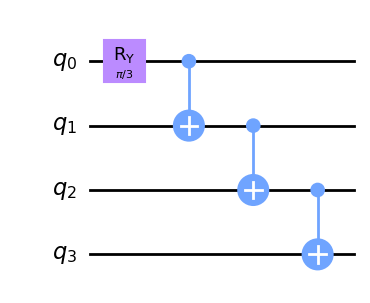

In [4]:
circuit = QuantumCircuit(4) # creating a quantum circuit with 4 qubits and 4 classical bits
circuit.ry(pi/3,0) # applied a ry gate to rotate the first qubit pi/3 to simulate a result or 70:30
# applying cnot gate on all the qubits to create a state |0000> |1111>
circuit.cx(0,1) 
circuit.cx(1,2)
circuit.cx(2,3)
circuit.draw(output='mpl')

In [5]:
array_to_latex(Simulators.UnitarySimulator(circuit))

<IPython.core.display.Latex object>

In [6]:
array_to_latex(Simulators.StateVectorSimulator(circuit))

<IPython.core.display.Latex object>

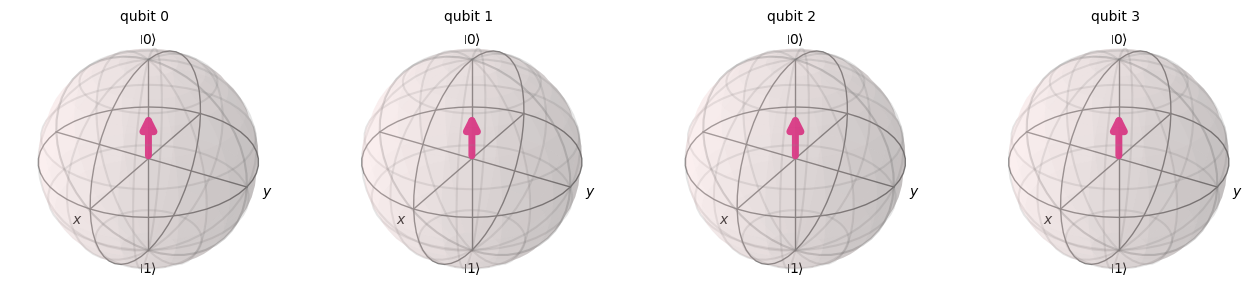

In [7]:
plot_bloch_multivector(Simulators.StateVectorSimulator(circuit))

In [8]:
circuit.measure_all() # measuring all qubits

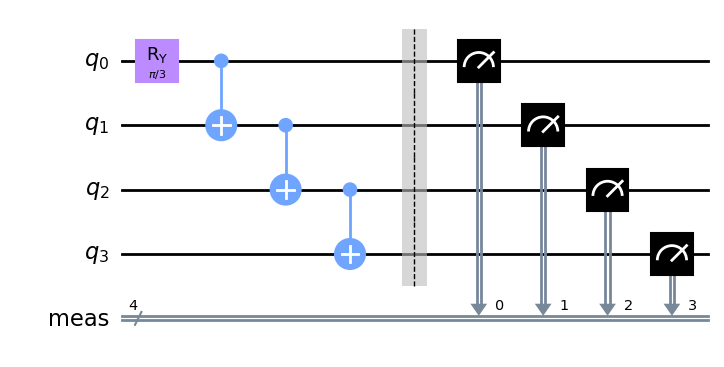

In [9]:
circuit.draw(output='mpl')

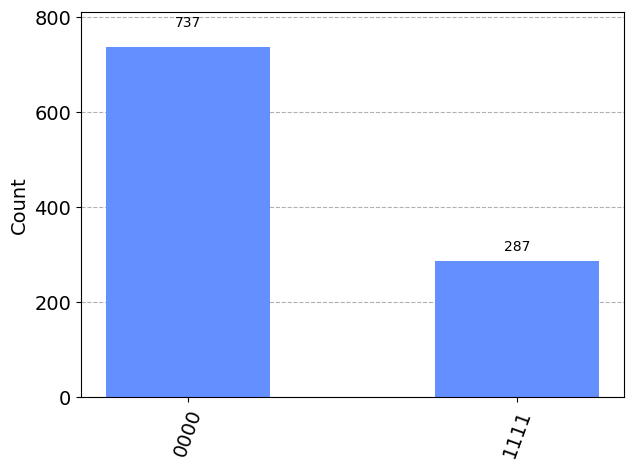

In [10]:
plot_histogram(Simulators.QasmSimulator(circuit,1024))

In [11]:
computer = QuantumComputer('ibm_lagos', circuit, 1024) # running on a real quantum computer

In [12]:
job_monitor , job = computer.RealQuantumComputer()

cnbaefhrbhc0008j63cg
Job Status: job has successfully run


In [20]:
job_result = job.result()


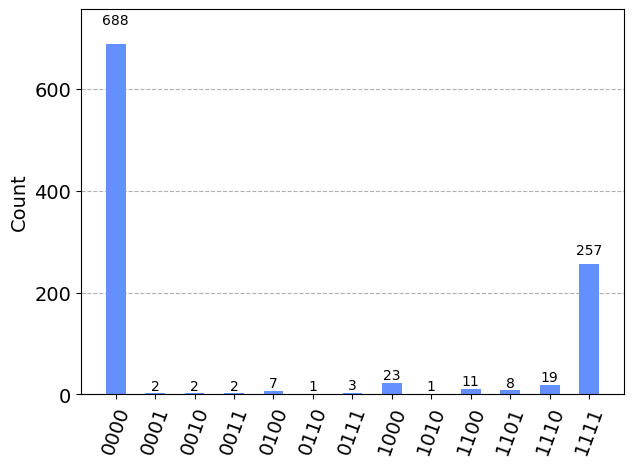

In [22]:
plot_histogram(job_result.get_counts(circuit))

In [13]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

/tmp/ipykernel_12282/2184433781.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [14]:
cal_circuit , state_label = complete_meas_cal(qr= circuit.qregs[0], circlabel='mitigatingcircuit') 

# creating the calc_circuts and its states there will be 2^n circuits this case 16 circuits

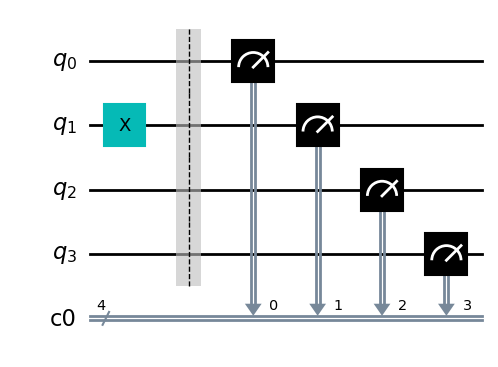

In [15]:
cal_circuit[2].draw(output='mpl')

In [16]:
print(*state_label) # printng all the statelabels

0000 0001 0010 0011 0100 0101 0110 0111 1000 1001 1010 1011 1100 1101 1110 1111


In [19]:
computer2 = QuantumComputer('ibm_lagos' ,cal_circuit,1024) 
cal_monitor, cal_job = computer2.RealQuantumComputer() # running all 16 calc_circuits on the real quantum computer

cnbaf85hga30008eyrr0
Job Status: job has successfully run


In [23]:
cal_result = cal_job.result()

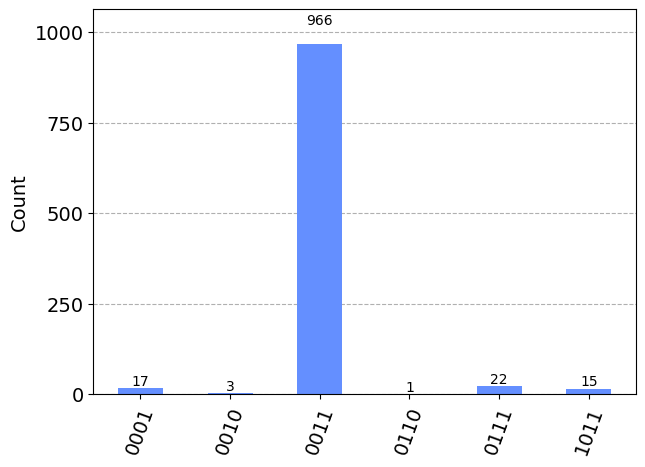

In [28]:
plot_histogram(cal_result.get_counts(cal_circuit[3]))

In [29]:
measurement_filter = CompleteMeasFitter(cal_result, state_label) # creating the measurement filter using the
# results from the results from the quantum computer

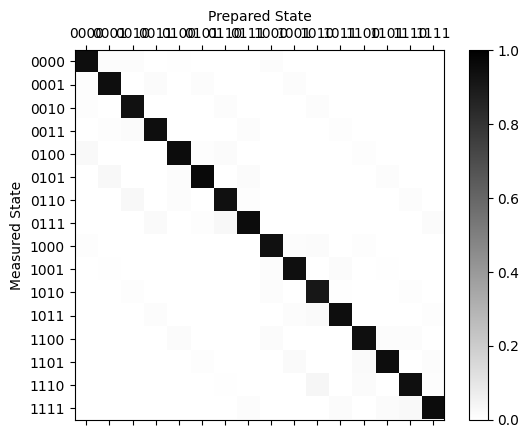

In [30]:
measurement_filter.plot_calibration() # plotting the calibration result from the measurement filter the misclassification shows the errors

In [31]:
meas_filter = measurement_filter.filter 

In [38]:
mitigated_result = meas_filter.apply(job_result) # mitigating the result of the job result from the quantum computer

In [39]:
device_count = job_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit) # getting counts from the mitigated result

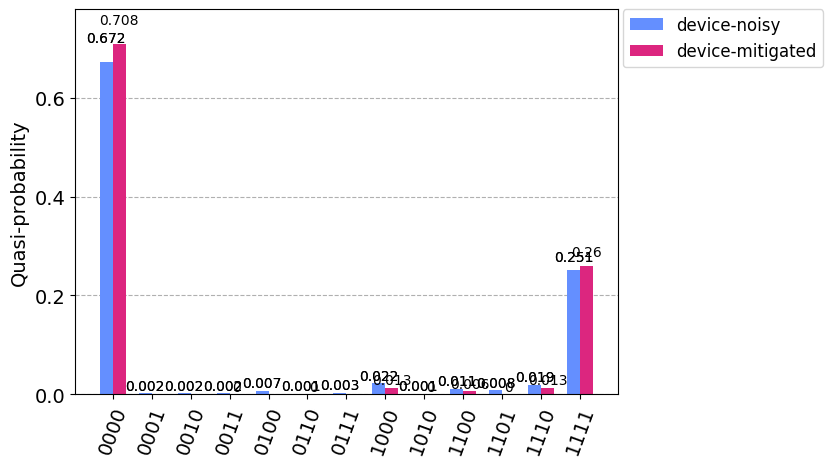

In [40]:
plot_histogram([device_count, mitigated_counts], legend=['device-noisy', 'device-mitigated'])

# from the plot we can see most of the quantum error is reduced and the mitigated result shows how the 
# result will be from a perfect quantum computer

## BitFLip ERROR

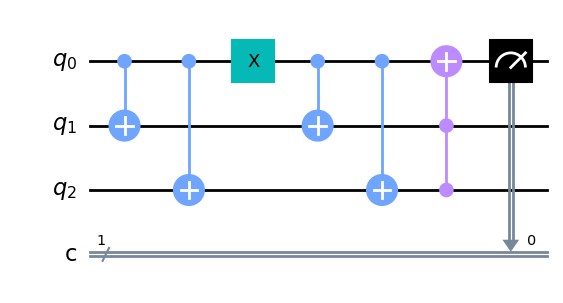

In [9]:
bit_flip_circuit = QuantumCircuit(3,1) # creating a quantum circuit with 3 qubits and 1 classical bit
bit_flip_circuit.cx(0,1)
bit_flip_circuit.cx(0,2) # creating a  controlled x gates on both ancillary qubits to flip them if an error occures
bit_flip_circuit.x(0) # creating a bitflip error on qubit 1
bit_flip_circuit.cx(0,1)
bit_flip_circuit.cx(0,2)
bit_flip_circuit.ccx(1,2,0) # creatinga controlled control x gate to flip back the original qibit to its original state
bit_flip_circuit.measure(0,0)
bit_flip_circuit.draw(output='mpl')

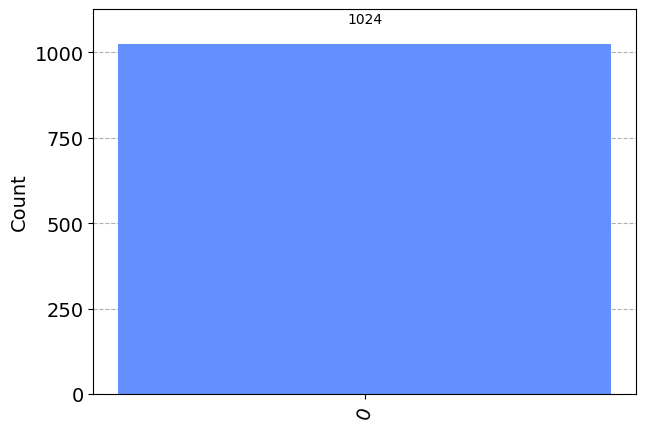

In [14]:
plot_histogram(Simulators.QasmSimulator(bit_flip_circuit, 1024))

In [17]:
# Testing on an actual Quantum Computer

real = QuantumComputer('ibm_nairobi', bit_flip_circuit, 1024)
job_monitor , job = real.RealQuantumComputer()

cng0z74njjq0008ad0x0
Job Status: job has successfully run
